In [18]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')
import numpy as np
import pandas as pd
from base import BaseModel
from stats import loglikelihood_normal
from datetime import timedelta, datetime
from monthdelta import monthdelta
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
class EWMA(BaseModel):
    def __init__(self, plot = True, lam = 0.94, *args):
        self.plot = plot
        self.lam = 0.94
        self.args = args
    
    def initialize_params(self, y):
        self.init_params = np.array([self.lam])
        return self.init_params
    
    def model_filter(self, params, y):
        T = y.shape[0]
        sigma2 = np.zeros(T)
        lamb = params
        
        for t in range(T):
            if t == 0:
                sigma2[t] = 1.0
            else:
                sigma2[t] = lamb * sigma2[t - 1] + (1 - lamb) * y[t - 1] ** 2
        return sigma2
    
    def loglikelihood(self, params, y):
        sigma2 = self.model_filter(params, y)
        return loglikelihood_normal(y, sigma2)
    
    def simulate(self, lamb, T):
        sigma2 = np.zeros(T)
        ret = np.zeros(T)
        
        for t in range(T):
            if t == 0:
                sigma2[t] = 1.0
            else:
                sigma2[t] = lamb * sigma2[t - 1] + (1 - lamb) * ret[t - 1] ** 2
            ret[t] = np.random.normal(scale = np.sqrt(sigma2[t]))
            
        return ret, sigma2
    
class Panel_EWMA(BaseModel):
    def __init__(self, plot = True, lam = 0.94, *args):
        self.plot = plot
        self.lam = 0.94
        self.args = args
    
    def initialize_params(self, y):
        self.init_params = np.array([self.lam])
        return self.init_params
    
    def model_filter(self, params, y):
        T = y.shape[0]
        sigma2 = np.zeros(T)
        lamb = params
        
        for t in range(T):
            if t == 0:
                sigma2[t] = 1.0
            else:
                sigma2[t] = lamb * sigma2[t - 1] + (1 - lamb) * y[t - 1] ** 2
        return sigma2
    
    def loglikelihood(self, params, y):
        lls = 0
        
        for i in range(y.shape[1]):
            idx = np.where(np.isnan(y.iloc[:, i]) == False)[0]
            sig = self.model_filter(params, y.iloc[idx, i].values)
            if len(sig) == 0:
                lls += 0
            else:
                lls += loglikelihood_normal(y.iloc[idx, i].values, sig)
        return lls
    
    def forecast(self, y):
        row_nul = pd.DataFrame([[0]*y.shape[1]], columns = y.columns)
        y = y.append(row_nul)
        forecast = np.zeros(len(y.columns))
        for i in range(ret_mat.shape[1]):
            idx = np.where(np.isnan(y.iloc[:, i]) == False)[0]
            if len(idx) == 0:
                forecast[i] = np.nan
            else:
                sig = model.model_filter(model.optimized_params, y.iloc[idx, i].values)
                forecast[i] = sig[-1]
        return forecast
    
    def simulate(self, lamb = 0.94, T = 500, num = 100):
        sigma2 = np.zeros((T, num))
        r = np.zeros((T, num))
        
        for t in range(T):
            if t == 0:
                sigma2[t] = 1.0
            else:
                sigma2[t] = lamb * sigma2[t - 1] + (1 - lamb) * r[t - 1] ** 2
            r[t] = np.random.normal(0.0, np.sqrt(sigma2[t]), size = num)
        return r, sigma2

In [20]:
model = EWMA()

In [21]:
y, sigma2 = model.simulate(lamb = 0.94, T = 1000)

In [22]:
model.fit(['01'], y)

Loglikelihood:  1.3450246431436617 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.952176        0.039875      0.874023        1.03033


In [7]:
def create_sim(num_of_sim = 500, length = 1000, param = 0.94, plot = False):
    lamb = np.zeros(num_of_sim)
    
    model = EWMA(plot = plot)
    for t in range(num_of_sim):
        y, _ = model.simulate(lamb = param, T = length)
        model.fit(['01'], y)
        lamb[t] = model.optimized_params
    return pd.DataFrame(data = lamb)

In [8]:
sim1 = create_sim(length=500)

In [9]:
sim2 = create_sim()

In [10]:
sim3 = create_sim(length = 2000)

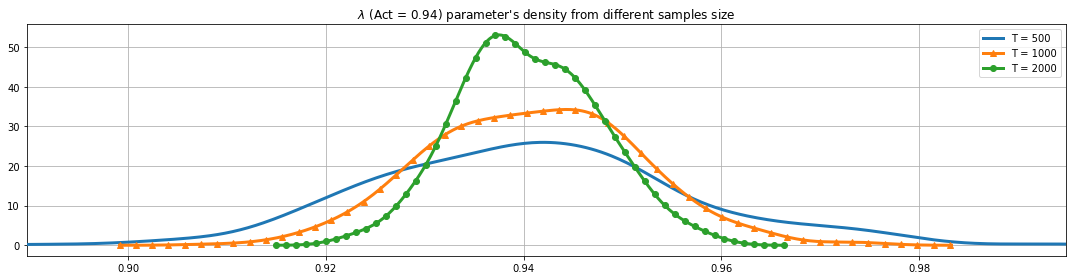

In [12]:
lamb1 = sm.nonparametric.KDEUnivariate(sim1.values).fit()
lamb2 = sm.nonparametric.KDEUnivariate(sim2.values).fit()
lamb3 = sm.nonparametric.KDEUnivariate(sim3.values).fit()

fig , ax = plt.subplots(1, 1, figsize=(15, 4), tight_layout=True)

ax.plot(lamb1.support, lamb1.density, lw = 3, label = 'T = 500', zorder = 10)
ax.plot(lamb2.support, lamb2.density, lw = 3, label = 'T = 1000', marker = '^', markevery = 10, zorder = 10)
ax.plot(lamb3.support, lamb3.density, lw = 3, label = 'T = 2000', marker = 'o', markevery = 10, zorder = 10)
ax.set_title(r'$\lambda$'+" (Act = 0.94) parameter's density from different samples size")
ax.grid(True, zorder = -5)
ax.set_xlim((np.min(sim1.values), np.max(sim1.values)))
ax.legend(loc = 'best')

plt.show()

In [23]:
model = Panel_EWMA()

In [24]:
y, _ = model.simulate()

In [25]:
model.fit(['01'], pd.DataFrame(y))

Loglikelihood:  103.91474272679727 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940087        0.005122      0.930048       0.950125


In [27]:
def create_sim(num_of_sim = 500, length = 500, param = 0.94, num_of_asset = 100, plot = False):
    lamb = np.zeros(num_of_sim)
    
    model = Panel_EWMA(plot = plot)
    for t in range(num_of_sim):
        y, _ = model.simulate(lamb = param, T = length, num = num_of_asset)
        model.fit(['01'], pd.DataFrame(y))
        lamb[t] = model.optimized_params
    return pd.DataFrame(data = lamb)

In [28]:
sim11 = create_sim(plot = True)

Loglikelihood:  109.50560402462132 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94143         0.00522      0.931199        0.95166
Loglikelihood:  103.9342508261713 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94005        0.005092       0.93007       0.950029
Loglikelihood:  97.19937970610047 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941233        0.005141      0.931157       0.951309
Loglikelihood:  103.9192783837336 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939057        0.005008      0.929242       0.948873
Loglikelihood:  105.38675324988328 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939788        0.005039      0.929911       0.949665
Loglikelihood:  104.01834306210674 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938831        0.005082       0.92887       0.948792
Loglikelihood:  100.8350114666579 

   Parameters  Standard Error  95% CI

Loglikelihood:  101.17051816565164 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938688        0.005028      0.928833       0.948544
Loglikelihood:  102.39554150757779 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940933        0.005269      0.930607        0.95126
Loglikelihood:  109.04803469925315 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941866        0.005167      0.931739       0.951993
Loglikelihood:  102.86375218733784 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938498        0.005084      0.928533       0.948463
Loglikelihood:  102.5571838922641 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940146        0.005073      0.930204       0.950089
Loglikelihood:  105.62977357708338 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942061        0.005203      0.931863       0.952259
Loglikelihood:  103.0540498637789 

   Parameters  Standard Error  95% 

Loglikelihood:  96.90299548967582 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940229        0.005175      0.930086       0.950373
Loglikelihood:  97.92111594002989 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940337         0.00508       0.93038       0.950294
Loglikelihood:  98.82208713503282 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939878        0.005136      0.929811       0.949944
Loglikelihood:  100.42457042094811 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94075        0.005146      0.930664       0.950837
Loglikelihood:  106.56501337723854 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938206        0.005208      0.927999       0.948413
Loglikelihood:  110.07892036195933 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939844        0.005118      0.929813       0.949876
Loglikelihood:  105.05646254841062 

   Parameters  Standard Error  95% C

Loglikelihood:  108.176906706953 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940014        0.009033      0.922309       0.957719
Loglikelihood:  109.82310016793645 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940896        0.005165      0.930773       0.951019
Loglikelihood:  106.76935905690101 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938872        0.005154       0.92877       0.948974
Loglikelihood:  105.2524117465899 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940842        0.005066      0.930913       0.950771
Loglikelihood:  99.09091807515375 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940947        0.005077      0.930996       0.950898
Loglikelihood:  99.43897357687824 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939796        0.005151      0.929699       0.949892
Loglikelihood:  100.12304987825813 

   Parameters  Standard Error  95% CI 

Loglikelihood:  105.03702488056835 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94149         0.00521      0.931278       0.951701
Loglikelihood:  104.92396684307056 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940395        0.004958      0.930678       0.950112
Loglikelihood:  103.03685304604862 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938756        0.005102      0.928757       0.948755
Loglikelihood:  100.32671878107118 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.936858        0.004889      0.927276        0.94644
Loglikelihood:  97.00986900534255 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941235        0.005099       0.93124       0.951229
Loglikelihood:  103.65638978333328 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939795        0.005109      0.929781       0.949808
Loglikelihood:  97.92552893693156 

   Parameters  Standard Error  95% 

Loglikelihood:  96.52387379714051 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937483        0.004903      0.927873       0.947093
Loglikelihood:  111.39727368771666 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93957        0.005223      0.929333       0.949808
Loglikelihood:  105.7370688491051 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940021        0.009033      0.922316       0.957727
Loglikelihood:  101.95740387403039 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938301        0.005031       0.92844       0.948161
Loglikelihood:  96.59609172215735 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938169        0.005135      0.928105       0.948234
Loglikelihood:  98.32364962157958 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940191        0.005018      0.930355       0.950027
Loglikelihood:  99.47724354552803 

   Parameters  Standard Error  95% CI 

Loglikelihood:  113.40708150999131 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941474        0.005232       0.93122       0.951728
Loglikelihood:  104.85758442169589 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939504        0.004987      0.929729       0.949279
Loglikelihood:  110.84374764796256 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941892         0.00521      0.931681       0.952103
Loglikelihood:  93.7182358970187 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939187        0.004986      0.929415       0.948958
Loglikelihood:  106.6149485618094 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941829        0.005245      0.931548       0.952109
Loglikelihood:  104.732707731022 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94131        0.005242      0.931035       0.951585
Loglikelihood:  103.28118574330792 

   Parameters  Standard Error  95% CI 

Loglikelihood:  111.01122999594392 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93875        0.005072      0.928809       0.948692
Loglikelihood:  101.82857252017784 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939139        0.005047      0.929247        0.94903
Loglikelihood:  99.884060092182 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940922        0.005163      0.930803       0.951042
Loglikelihood:  103.42276219659423 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938608        0.004993      0.928821       0.948394
Loglikelihood:  104.86412337205253 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939533        0.005173      0.929393       0.949672
Loglikelihood:  104.76399433174119 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941061        0.005157      0.930954       0.951167
Loglikelihood:  105.03417494347741 

   Parameters  Standard Error  95% C

Loglikelihood:  107.08741493451443 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941724        0.005221      0.931492       0.951956
Loglikelihood:  109.11544890373241 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941392        0.005269      0.931066       0.951719
Loglikelihood:  100.93034744083133 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937859        0.005047      0.927967       0.947751
Loglikelihood:  111.56712449461638 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.943712        0.005254      0.933415       0.954009
Loglikelihood:  101.78032667175607 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94118        0.005143        0.9311        0.95126
Loglikelihood:  104.5750281834718 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940084        0.005152      0.929986       0.950183
Loglikelihood:  103.48127230291193 

   Parameters  Standard Error  95%

Loglikelihood:  102.99930550459048 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939913        0.005069      0.929978       0.949847
Loglikelihood:  105.4149184875561 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939727        0.005007      0.929914        0.94954
Loglikelihood:  102.51201776930245 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940259        0.009032      0.922556       0.957963
Loglikelihood:  103.00007829424939 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941334        0.005148      0.931245       0.951424
Loglikelihood:  100.04570209581487 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940896        0.005075      0.930949       0.950843
Loglikelihood:  108.40760797507988 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941299        0.005142      0.931222       0.951377
Loglikelihood:  106.30023428925477 

   Parameters  Standard Error  95%

In [29]:
sim22 = create_sim(num_of_asset = 50, plot = True)

Loglikelihood:  48.766959276232384 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939416        0.007065      0.925569       0.953263
Loglikelihood:  49.78384715907015 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940955        0.007135      0.926971       0.954939
Loglikelihood:  51.25881305367453 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938319        0.007145      0.924314       0.952323
Loglikelihood:  54.97816817740632 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938224        0.007181      0.924149       0.952299
Loglikelihood:  51.33102839755102 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942708         0.00736      0.928283       0.957134
Loglikelihood:  48.782180230895264 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937027        0.007067      0.923176       0.950879
Loglikelihood:  54.94176709938536 

   Parameters  Standard Error  95% CI 

Loglikelihood:  43.85821711262084 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.936929        0.006933       0.92334       0.950518
Loglikelihood:  43.68921070944833 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937712        0.007046      0.923902       0.951522
Loglikelihood:  56.84965625043018 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939827        0.007356      0.925409       0.954245
Loglikelihood:  54.151728435451 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942233         0.00737      0.927787       0.956678
Loglikelihood:  53.80619454990279 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940605        0.007284      0.926328       0.954883
Loglikelihood:  47.84336666473343 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938331        0.006968      0.924675       0.951988
Loglikelihood:  56.007815683095494 

   Parameters  Standard Error  95% CI Low

Loglikelihood:  38.88074023771916 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938777        0.007025      0.925009       0.952545
Loglikelihood:  48.2883082560534 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939916        0.007072      0.926054       0.953778
Loglikelihood:  49.258302732394306 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941354        0.007399      0.926853       0.955856
Loglikelihood:  47.096421436362526 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938264        0.006792      0.924952       0.951577
Loglikelihood:  42.723671486959105 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938473        0.007085      0.924586       0.952359
Loglikelihood:  50.37120723475661 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937987        0.007117      0.924039       0.951936
Loglikelihood:  46.35687043845425 

   Parameters  Standard Error  95% CI 

Loglikelihood:  48.524124751118826 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941286          0.0073      0.926979       0.955593
Loglikelihood:  50.39613428619016 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.943252         0.00735      0.928847       0.957657
Loglikelihood:  47.38348917833847 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938832        0.007435       0.92426       0.953405
Loglikelihood:  48.44260645419475 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941172        0.007159      0.927142       0.955203
Loglikelihood:  51.12173868818429 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.936355        0.007041      0.922556       0.950155
Loglikelihood:  59.17319895099532 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941917        0.007615      0.926993       0.956842
Loglikelihood:  49.10769763595788 

   Parameters  Standard Error  95% CI L

Loglikelihood:  53.16218077056647 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940082          0.0074      0.925579       0.954585
Loglikelihood:  50.86236153268884 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93844        0.007213      0.924302       0.952578
Loglikelihood:  49.818303420873484 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940599         0.00721      0.926468       0.954729
Loglikelihood:  47.97072905097141 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942136        0.007306      0.927817       0.956456
Loglikelihood:  54.088333286539225 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939185        0.007222       0.92503       0.953339
Loglikelihood:  51.601460516276475 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94329          0.0075       0.92859       0.957989
Loglikelihood:  53.841568479420225 

   Parameters  Standard Error  95% C

Loglikelihood:  51.47799365781422 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939268        0.007115      0.925323       0.953212
Loglikelihood:  50.886940878940926 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941987        0.007519       0.92725       0.956724
Loglikelihood:  53.66622254412667 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941165        0.007282      0.926892       0.955437
Loglikelihood:  51.3044855112529 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938364        0.006898      0.924845       0.951883
Loglikelihood:  46.235496972240895 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94016         0.00692      0.926597       0.953723
Loglikelihood:  54.16921939971759 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939633        0.007304      0.925318       0.953949
Loglikelihood:  55.820145570994704 

   Parameters  Standard Error  95% CI 

Loglikelihood:  47.70685545542586 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939162        0.007067      0.925311       0.953012
Loglikelihood:  48.06246792980158 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937606        0.006923      0.924037       0.951175
Loglikelihood:  54.87047980917887 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941213        0.007297      0.926911       0.955514
Loglikelihood:  53.51528815321625 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941514        0.007405         0.927       0.956028
Loglikelihood:  45.02148569176161 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.936496        0.007032      0.922712       0.950279
Loglikelihood:  51.34291279309205 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939574        0.007187      0.925488       0.953659
Loglikelihood:  47.93063089480458 

   Parameters  Standard Error  95% CI Lo

Loglikelihood:  43.84331632360403 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.936155        0.006847      0.922736       0.949575
Loglikelihood:  54.26385729384431 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941435        0.007234      0.927257       0.955614
Loglikelihood:  47.458276924594614 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939388        0.007169      0.925337       0.953439
Loglikelihood:  48.60512585743789 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940582        0.007254      0.926364       0.954799
Loglikelihood:  49.53261480689239 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941184        0.007113      0.927243       0.955126
Loglikelihood:  50.337541325817995 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939522        0.007475       0.92487       0.954173
Loglikelihood:  57.554171052707986 

   Parameters  Standard Error  95% CI

Loglikelihood:  45.23620576284493 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939057        0.006993      0.925351       0.952762
Loglikelihood:  56.012959894566556 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939641        0.007283      0.925367       0.953916
Loglikelihood:  49.72539721416553 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941664        0.007245      0.927464       0.955863
Loglikelihood:  44.4093116137544 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939425        0.007021      0.925663       0.953187
Loglikelihood:  49.46384418610886 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938257         0.00709       0.92436       0.952154
Loglikelihood:  48.52966693443121 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938865         0.00699      0.925166       0.952564
Loglikelihood:  50.75064735212913 

   Parameters  Standard Error  95% CI Lo

Loglikelihood:  44.259186117736746 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940897        0.007216      0.926754       0.955039
Loglikelihood:  52.78300343414145 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93925        0.007143       0.92525       0.953251
Loglikelihood:  57.14597533823193 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942323        0.007467      0.927688       0.956957
Loglikelihood:  51.19615535037297 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93697        0.007254      0.922753       0.951186
Loglikelihood:  49.634271570477864 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.943186        0.007427       0.92863       0.957743
Loglikelihood:  58.94719596778072 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.943973        0.007489      0.929295       0.958651
Loglikelihood:  53.68460469107144 

   Parameters  Standard Error  95% CI 

In [30]:
sim33 = create_sim(num_of_asset = 200, plot = True)

Loglikelihood:  208.31270321014568 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941769        0.003683       0.93455       0.948989
Loglikelihood:  200.12032564180046 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940673        0.003617      0.933584       0.947762
Loglikelihood:  199.29557058752079 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940902        0.003615      0.933816       0.947987
Loglikelihood:  204.34717177399187 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940793        0.003639      0.933662       0.947925
Loglikelihood:  210.9087901168977 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939692        0.003647      0.932544       0.946841
Loglikelihood:  215.90200377052795 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940194        0.003683      0.932976       0.947413
Loglikelihood:  205.88180909251773 

   Parameters  Standard Error  95%

Loglikelihood:  209.44682378301172 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939808        0.003626        0.9327       0.946915
Loglikelihood:  198.58767911881907 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938463        0.003529      0.931546       0.945379
Loglikelihood:  204.9655917522475 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939364         0.00361      0.932288       0.946441
Loglikelihood:  197.47839903837186 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939575        0.003592      0.932534       0.946615
Loglikelihood:  193.42415099841486 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938615        0.003549       0.93166       0.945571
Loglikelihood:  203.30438667373235 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938989        0.003589      0.931955       0.946023
Loglikelihood:  192.32004581243834 

   Parameters  Standard Error  95%

Loglikelihood:  207.59918982345783 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939717        0.003593      0.932676       0.946758
Loglikelihood:  202.32652668807646 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941092         0.00364      0.933957       0.948226
Loglikelihood:  215.87941898880837 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941682         0.00362      0.934586       0.948778
Loglikelihood:  213.92779033625922 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938664        0.003665      0.931481       0.945846
Loglikelihood:  202.83583379097522 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940437        0.003621       0.93334       0.947533
Loglikelihood:  224.91898425802518 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938778        0.003597      0.931728       0.945828
Loglikelihood:  211.43158820576414 

   Parameters  Standard Error  95

Loglikelihood:  204.96791428367837 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938012        0.003553      0.931049       0.944975
Loglikelihood:  185.30861902974377 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940325        0.003555      0.933358       0.947292
Loglikelihood:  191.71656201296622 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938209         0.00353      0.931289       0.945128
Loglikelihood:  200.57848804406717 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93977        0.003657      0.932602       0.946938
Loglikelihood:  194.54721417432646 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937643        0.003564      0.930657       0.944628
Loglikelihood:  197.67591291014998 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939886        0.003608      0.932815       0.946957
Loglikelihood:  207.3366621884293 

   Parameters  Standard Error  95%

Loglikelihood:  201.33002160589245 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93929        0.003592       0.93225       0.946331
Loglikelihood:  187.59255661729426 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939085        0.003568      0.932091       0.946078
Loglikelihood:  198.30340632449156 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939857        0.003582      0.932836       0.946878
Loglikelihood:  202.1690948177047 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940543         0.00364      0.933409       0.947677
Loglikelihood:  222.0643581443829 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941468        0.003705      0.934207       0.948729
Loglikelihood:  206.5960888461012 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94003        0.003629      0.932917       0.947143
Loglikelihood:  198.7854300552709 

   Parameters  Standard Error  95% CI

Loglikelihood:  200.80917017646502 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938002        0.003509      0.931124       0.944879
Loglikelihood:  214.44485603591508 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940041        0.003636      0.932914       0.947168
Loglikelihood:  208.18918930064046 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93953        0.003594      0.932486       0.946574
Loglikelihood:  200.25219309570673 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93986        0.003574      0.932856       0.946864
Loglikelihood:  204.7342362600918 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942113          0.0037      0.934862       0.949364
Loglikelihood:  206.0492886166161 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939244        0.003629      0.932132       0.946356
Loglikelihood:  196.4184068399755 

   Parameters  Standard Error  95% C

Loglikelihood:  206.24107813199214 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939238        0.003642        0.9321       0.946376
Loglikelihood:  207.3138989839648 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939609        0.003622       0.93251       0.946707
Loglikelihood:  205.27486441112424 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939833        0.003619      0.932739       0.946927
Loglikelihood:  218.96603542472533 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941395         0.00366       0.93422       0.948569
Loglikelihood:  206.5933910948523 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941364        0.003664      0.934182       0.948546
Loglikelihood:  209.39631260379102 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940231        0.003636      0.933104       0.947358
Loglikelihood:  216.3072578223797 

   Parameters  Standard Error  95% C

Loglikelihood:  199.0473299719419 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940441        0.003659       0.93327       0.947613
Loglikelihood:  204.31006472938583 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939509        0.003626      0.932402       0.946616
Loglikelihood:  200.96975162913068 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939277        0.003569      0.932283       0.946272
Loglikelihood:  191.91945581902405 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938303        0.003537      0.931369       0.945236
Loglikelihood:  208.11067658563996 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939653        0.003564      0.932667       0.946639
Loglikelihood:  202.14349052349192 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940566         0.00367      0.933373       0.947759
Loglikelihood:  196.65334669201482 

   Parameters  Standard Error  95%

Loglikelihood:  216.1570054974619 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940431        0.003616      0.933344       0.947517
Loglikelihood:  209.6762840265582 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939784        0.003599       0.93273       0.946838
Loglikelihood:  208.95455447673186 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938334          0.0036      0.931277        0.94539
Loglikelihood:  210.19094088544455 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939217        0.003647       0.93207       0.946365
Loglikelihood:  191.28728698668976 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938934        0.003535      0.932006       0.945862
Loglikelihood:  205.9904316043215 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939733        0.003637      0.932606       0.946861
Loglikelihood:  213.70833027666498 

   Parameters  Standard Error  95% C

Loglikelihood:  203.15463806547191 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940289        0.003638      0.933159       0.947418
Loglikelihood:  207.4331358571297 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94205        0.003669      0.934859        0.94924
Loglikelihood:  194.92648344581528 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939848        0.003586       0.93282       0.946876
Loglikelihood:  202.50783896137665 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94095        0.003609      0.933876       0.948023
Loglikelihood:  203.2058109536095 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940126         0.00358       0.93311       0.947143
Loglikelihood:  211.10223610860578 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939069        0.003609      0.931996       0.946143
Loglikelihood:  202.8297508260434 

   Parameters  Standard Error  95% C

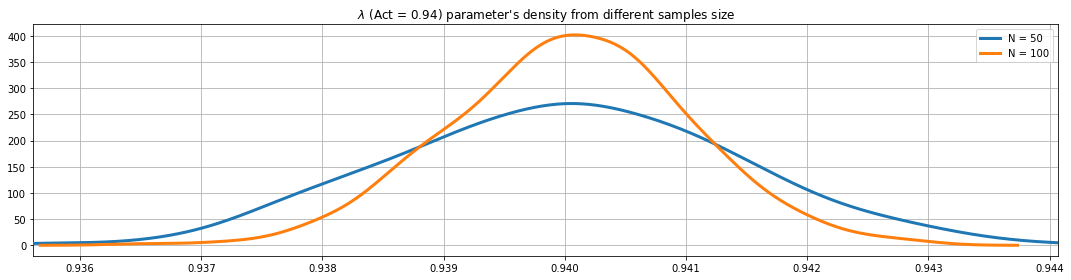

In [38]:
lamb1 = sm.nonparametric.KDEUnivariate(sim11.values).fit()
lamb2 = sm.nonparametric.KDEUnivariate(sim22.values).fit()
lamb3 = sm.nonparametric.KDEUnivariate(sim33.values).fit()

fig , ax = plt.subplots(1, 1, figsize=(15, 4), tight_layout=True)

ax.plot(lamb2.support, lamb2.density, lw = 3, label = 'N = 50', zorder = 10)
ax.plot(lamb1.support, lamb1.density, lw = 3, label = 'N = 100', marker = '^', markevery = 10, zorder = 10)
ax.plot(lamb3.support, lamb3.density, lw = 3, label = 'N = 200', marker = 'o', markevery = 10, zorder = 10)
ax.set_title(r'$\lambda$'+" (Act = 0.94) parameter's density from different samples size")
ax.grid(True, zorder = -5)
ax.set_xlim((np.min(sim22.values), np.max(sim22.values)))
ax.legend(loc = 'best')

plt.savefig('C:/Users/peter/Desktop/volatility-forecasting/results/panel_ewma_sim.png')
plt.show()

In [20]:
ret_matrix = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/ret_matrix.csv')
ret_matrix.set_index(pd.to_datetime(ret_matrix.Date), inplace = True)
ret_matrix = ret_matrix.iloc[:, 1:] * 100

ret_mat = ret_matrix.iloc[1:, :]
nan_cols = np.where(ret_mat.isna().sum().values == 1)[0]
nan_index = np.where(ret_mat.iloc[:, nan_cols].isna() == True)[0]

if len(set(nan_index)) == 1.0:
    ret_mat = ret_mat.drop([ret_mat.index[nan_index[0]]])

ret_mat.pop('AMCR')

Date
1999-11-19         NaN
1999-11-22         NaN
1999-11-23         NaN
1999-11-24         NaN
1999-11-26         NaN
                ...   
2020-10-26   -0.031484
2020-10-27   -0.005660
2020-10-28   -0.023936
2020-10-29    0.017292
2020-10-30   -0.006689
Name: AMCR, Length: 5270, dtype: float64

In [21]:
y = ret_mat[(ret_mat.index >= datetime(1999,12,1)) & (ret_mat.index < datetime(2005, 1, 1))]

In [22]:
model = Panel_EWMA()

In [24]:
model.fit(['01'], y)

Loglikelihood:  945.2677241498297 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.952133        0.001385      0.949418       0.954848
